# Illustrating Observed and Intrinsic Object Properties:
# SDSS "Galaxy" Sizes


* In a catalog, each galaxy's measurements come with "error bars" providing information about how *uncertain* we should be about each property of each galaxy.

* This means that the distribution of "observed" galaxy properties (as reported in the catalog) is not the same as the underlying or "intrinsic" distribution.

* Let's look at the distribution of *observed sizes* in the SDSS photometric object catalog.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function
import numpy as np
import SDSS
import pandas as pd
import matplotlib
%matplotlib inline

In [3]:
galaxies = "SELECT top 1000 \
petroR50_i AS size, \
petroR50Err_i AS err \
FROM PhotoObjAll \
WHERE \
(type = '3' AND petroR50Err_i > 0)"
print (galaxies)

SELECT top 1000 petroR50_i AS size, petroR50Err_i AS err FROM PhotoObjAll WHERE (type = '3' AND petroR50Err_i > 0)


In [4]:
# Download data. This can take a few moments...
data = SDSS.select(galaxies)
data.head()

,size,err
0,3.183596,0.025126
1,3.065464,0.011983
2,20.184450,12.358810
3,3.140940,0.019812
4,2.944434,0.005674


In [5]:
!mkdir -p downloads
data.to_csv("downloads/SDSSgalaxysizes.csv")

## The Distribution of Observed SDSS "Galaxy" Sizes

Let's look at a histogram of galaxy sizes, for 1000 objects classified as "galaxies".

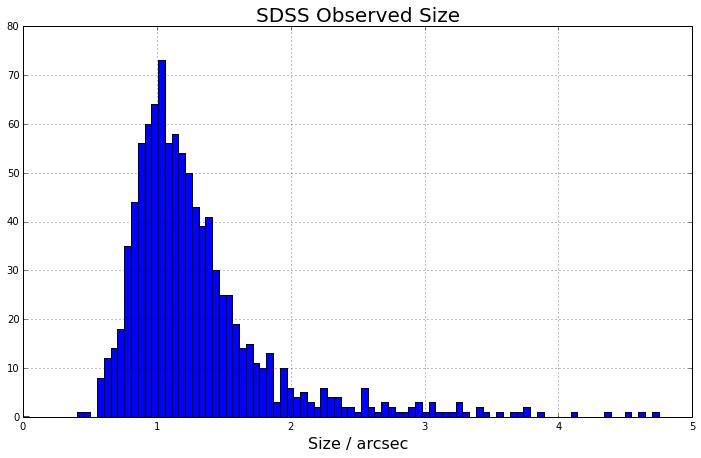

In [23]:
data = pd.read_csv("downloads/SDSSgalaxysizes.csv",usecols=["size","err"])

data['size'].hist(bins=np.linspace(0.0,5.0,100),figsize=(12,7))
matplotlib.pyplot.xlabel('Size / arcsec',fontsize=16)
matplotlib.pyplot.title('SDSS Observed Size',fontsize=20)

Things to notice:

* No small objects (why not?)
* A "tail" to large size
* Some very large sizes that look a little odd



Are these large galaxies *actually* large, or have they just been measured that way?
Let's look at the reported uncertainties on these sizes:

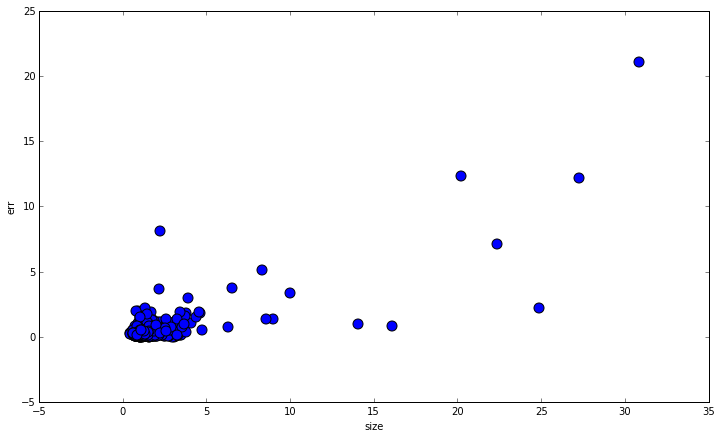

In [8]:
data.plot(kind='scatter', x='size', y='err',s=100,figsize=(12,7));

## Generating Mock Data

* Let's look at how distributions like this one can come about, by making a **generative model** for this dataset.


* First, let's imagine a set of perfectly measured galaxies. They won't all have the same size, because the Universe isn't like that. Let's suppose the logarithm of their *intrinsic sizes* are drawn from a Gaussian distribution of width $S$ and mean $\mu$. 


* To model one mock galaxy, we *draw a sample from this distribution*. To model the whole dataset, we draw 1000 samples.


* Note that this is a similar activity to making random catalogs for use in correlation function summaries; here, though, we want to start comparing real data with mock data to begin *understanding* it. 

In [9]:
def generate_galaxies(mu=np.log10(1.5),S=0.3,N=1000):
    return pd.DataFrame({'size' : 10.0**(mu + S*np.random.randn(N))})

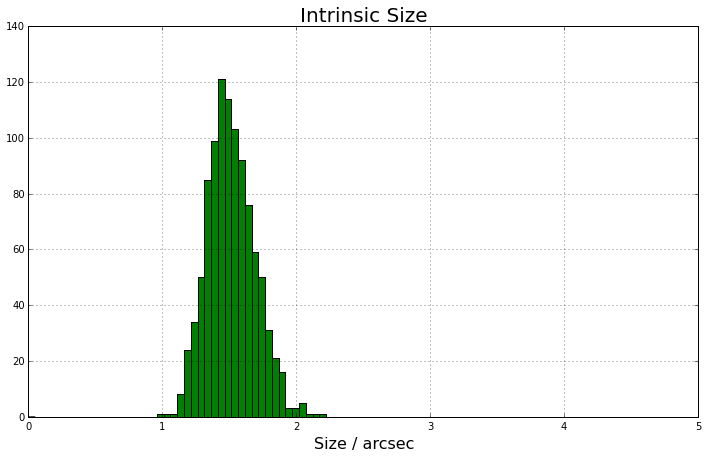

In [22]:
mu = np.log10(1.5)
S = 0.05
intrinsic = generate_galaxies(mu=mu,S=S,N=1000)

intrinsic.hist(bins=np.linspace(0.0,5.0,100),figsize=(12,7),color='green')
matplotlib.pyplot.xlabel('Size / arcsec',fontsize=16)
matplotlib.pyplot.title('Intrinsic Size',fontsize=20)

Now let's add some observational uncertainty. We can model this by drawing random Gaussian offsets $\epsilon$ and add one to each intrinsic size.

In [11]:
def make_noise(sigma=0.3,N=1000):
    return pd.DataFrame({'size' : sigma*np.random.randn(N)})

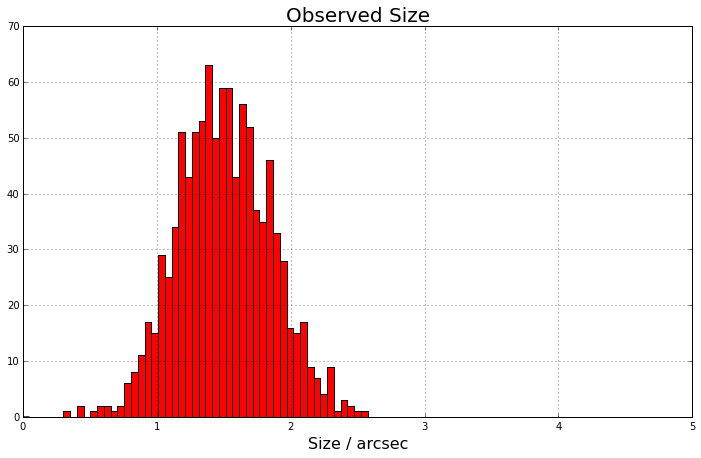

In [24]:
sigma = 0.3
errors = make_noise(sigma=sigma,N=1000)

observed = intrinsic + errors

observed.hist(bins=np.linspace(0.0,5.0,100),figsize=(12,7),color='red')
matplotlib.pyplot.xlabel('Size / arcsec',fontsize=16)
matplotlib.pyplot.title('Observed Size',fontsize=20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10b388390>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10ac82410>]], dtype=object)

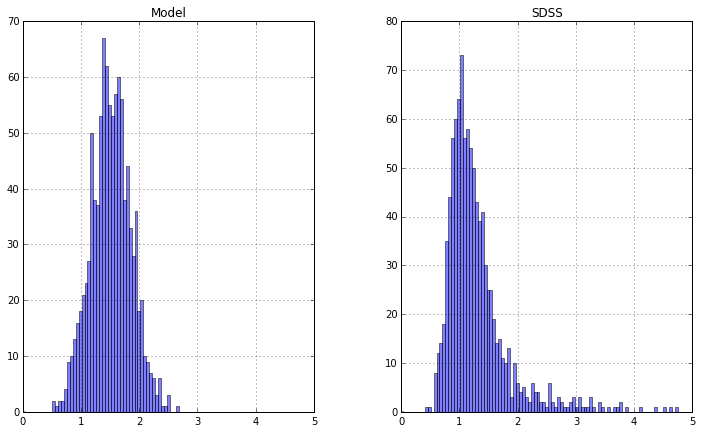

In [13]:
both = pd.DataFrame({'SDSS': data['size'], 'Model': observed['size']}, columns=['SDSS', 'Model'])
both.hist(alpha=0.5,bins=np.linspace(0.0,5.0,100),figsize=(12,7))

#### Q: How did we do? Is this a good model for our data?

Play around with the _parameters_ $\mu$, $S$ and $\sigma$ and see if you can get a better match to the observed distribution of sizes.

<br>

One last thing: let's look at the variances of these distributions.

Recall: 

$V(x) = \frac{1}{N} \sum_{i=1}^N (x_i - \nu)^2$

If $\nu$, the population mean of $x$, is not known, an _estimator_ for $V$ is 

$\hat{V}(x) = \frac{1}{N} \sum_{i=1}^N (x_i - \bar{x})^2$

where $\bar{x} = \frac{1}{N} \sum_{i=1}^N x_i$, the _sample mean_.

In [14]:
V_data = np.var(data['size'])

print ("Variance of the SDSS distribution = ",V_data)

Variance of the SDSS distribution =  3.84753190001


In [15]:
V_int   = np.var(intrinsic['size'])
V_noise = np.var(errors['size'])
V_obs   = np.var(observed['size'])

print ("Variance of the intrinsic distribution = ", V_int)
print ("Variance of the noise = ", V_noise)
print ("Variance of the observed distribution = ",  V_int + V_noise, \
  "cf", V_obs)

Variance of the intrinsic distribution =  0.0319501163967
Variance of the noise =  0.0837976669906
Variance of the observed distribution =  0.115747783387 cf 0.117171196533


You may recall this last result from previous statistics courses.

**Why is the variance of our mock dataset's galaxy sizes so much smaller than that of the SDSS sample?**




-----




## Sampling Distributions

In the above example we drew 1000 *samples* from two *probability distributions*:

* The intrinsic size distribution, ${\rm Pr}(R_{\rm true}|\mu,S)$


* The "error" distribution, ${\rm Pr}(R_{\rm obs}|R_{\rm true},\sigma)$



The procedure of drawing numbers from the first, and then adding numbers from the second, produced *mock data* - which then appeared to have been drawn from:

* ${\rm Pr}(R_{\rm obs}|\mu,S,\sigma)$

which is *broader* than either the intrinsic distribution or the error distribution.


#### Q: What would we do differently if we wanted to simulate 1 Galaxy?


The three distributions are related by an integral:

${\rm Pr}(R_{\rm obs}|\mu,S,\sigma) = \int {\rm Pr}(R_{\rm obs}|R_{\rm true},\sigma) \; {\rm Pr}(R_{\rm true}|\mu,S) \; dR_{\rm true}$


* Note that this is *not* a convolution, in general - but it's similar to one.


* When we only plot the 1D histogram of *observed* sizes, we are *summing over* or "marginalizing out" the intrinsic ones. 

## Probabilistic Graphical Models

We can draw a diagram representing the above combination of probability distributions, that:

* Shows the dependencies between variables

* Gives you a recipe for generating *mock data*


> [We can do this in python, using the `daft` package.](FirstPGM.ipynb):

In [ ]:
from IPython.display import Image
Image(filename="samplingdistributions.png",width=300)

### Interpreting PGMs

* Each "node" (circle or dot) in the graph above represents a *probability distribution* 


* Nodes marked with dots represent PDFs that are *delta functions* - that is, parameters that are asserted to have specific values (like we did with $\mu$ for example: ${\rm Pr}(\mu) = \delta(\mu - \log_{10}{1.5}$).


* The "edges" in the graph show the conditional dependence of the parameters with each other: a node with an edge leading to it is a *conditional probability distribution*.


* We do not need to specify the functional form for any of the other PDFs before writing down the PGM - it just illustrates the connections between parameters in our probabilistic model.


* It's often helpful to write down the PGM *before* writing down the probability distributions, as we'll see later.


* The integral over the intrinsic size is not implied by this graph: the PGM just shows how to generate observed sizes given other parameters.

### Q: Where should $\sigma$ go?

Talk to your neighbor about dependencies for a couple of minutes...